In [1]:
!mkdir variables && mv variables.* variables

mkdir: cannot create directory ‘variables’: File exists


## The GPT-2 Decoder Only Architecture  
<img src="https://i.stack.imgur.com/Kb8Gq.png" height=500 />

In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [103]:
# Hyperparameters

npx = 28
maxlen = npx*npx
embed_dim = 128
num_heads = 4
num_vocab = 256
num_layers = 1

num_epochs = 20
num_batch = 32

In [104]:
# Necessary imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys

TRAIN = True
RETRAIN = False
SAVE = False
CREATE_NEW = True
LOAD = False

In [105]:
# One block of the decoder

def causal_attention_mask(batch_size, n_dest, n_src, dtype):
  i = tf.range(n_dest)[:, None]
  j = tf.range(n_src)
  m = i >= j - n_src + n_dest
  mask = tf.cast(m, dtype)
  mask = tf.reshape(mask, [1, n_dest, n_src])
  mult = tf.concat(
      [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
  )
  return tf.tile(mask, mult)

class TransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads):
    super(TransformerBlock, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
        [layers.Dense(embed_dim*4, activation="relu"),
         tfa.layers.GELU(),
         layers.Dense(embed_dim, activation="relu")]
    )
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]
    seq_len = input_shape[1]
    causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
    attn_output, weights = self.att(inputs, inputs, attention_mask=causal_mask, return_attention_scores=True)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    return self.layernorm2(out1 + ffn_output)

In [106]:
# Embedding layer

class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

In [107]:
# Here, I will take a 2d npx*npx sequence as input then train

def create_model():
  inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
  embedding_layer = TokenAndPositionEmbedding(maxlen, num_vocab, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads)
  for i in range(num_layers):
    x = transformer_block(x)
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  outputs = layers.Dense(num_vocab)(x)
  model = keras.Model(inputs=inputs, outputs=[outputs, x])

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  model.compile(
      "adam", loss=[loss_fn, None],
  )   # No loss and optimization based on word embeddings from transformer block
  return model

In [108]:
if(CREATE_NEW):
  model = create_model()
elif (LOAD):
  model = keras.models.load_model('./')

In [109]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 token_and_position_embeddin  (None, 784, 128)         133120    
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  (None, 784, 128)         396032    
 ormerBlock)                                                     
                                                                 
 layer_normalization_8 (Laye  (None, 784, 128)         256       
 rNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 784, 256)          3302

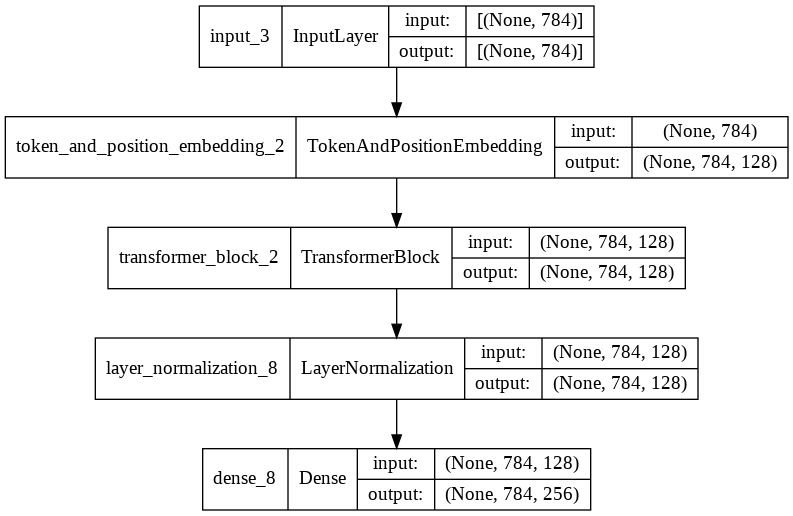

In [110]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [111]:
# The model is fine above below will be the data processing and training
# currently let it run on normal mnist data set

num_classes = 10
input_shape = (npx, npx, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

x_train = x_train[:10000, :]

x_train = tf.cast(tf.reshape(x_train, (x_train.shape[0], npx**2)), tf.int32)
x_test = tf.cast(tf.reshape(x_test, (x_test.shape[0], npx**2)), tf.int32)

y_train = tf.cast(x_train, tf.int32)
y_test = tf.cast(x_test, tf.int32)

sos = -1*tf.zeros((x_train.shape[0], 1), dtype=tf.int32)
x_train = tf.concat([sos, x_train[:, :-1]], 1)
x_test = tf.concat([sos, x_test[:, :-1]], 1)

# cropping the test images into half and padding the rest with zeros
# mask = [1 if i < maxlen//2 else 0 for i in range(maxlen)]
# x_test = x_test*mask
x_test = x_test[:, :maxlen//2]

In [112]:
if(TRAIN or RETRAIN):
  history = model.fit(
      x_train, y_train, batch_size=num_batch, epochs=num_epochs
  )

Epoch 1/20
313/313 [==============================] - 82s 255ms/step - loss: 1.0221 - dense_8_loss: 1.0221
Epoch 2/20
313/313 [==============================] - 80s 255ms/step - loss: 0.8989 - dense_8_loss: 0.8989
Epoch 3/20
313/313 [==============================] - 80s 255ms/step - loss: 0.8553 - dense_8_loss: 0.8553
Epoch 4/20
313/313 [==============================] - 80s 256ms/step - loss: 0.8077 - dense_8_loss: 0.8077
Epoch 5/20
313/313 [==============================] - 80s 255ms/step - loss: 0.7709 - dense_8_loss: 0.7709
Epoch 6/20
313/313 [==============================] - 80s 255ms/step - loss: 0.7482 - dense_8_loss: 0.7482
Epoch 7/20
313/313 [==============================] - 80s 255ms/step - loss: 0.7323 - dense_8_loss: 0.7323
Epoch 8/20
313/313 [==============================] - 80s 256ms/step - loss: 0.7199 - dense_8_loss: 0.7199
Epoch 9/20
313/313 [==============================] - 80s 256ms/step - loss: 0.7110 - dense_8_loss: 0.7110
Epoch 10/20
313/313 [================

In [124]:
SAVE = True
if(SAVE):
  model.save('./')

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In [114]:
!ls -lRah

.:
total 60K
drwxr-xr-x 1 root root 4.0K Nov 11 19:21 .
drwxr-xr-x 1 root root 4.0K Nov 11 19:05 ..
drwxr-xr-x 4 root root 4.0K Nov  1 13:34 .config
-rw-r--r-- 1 root root  44K Nov 11 20:08 model.png
drwxr-xr-x 1 root root 4.0K Nov  1 13:35 sample_data

./.config:
total 36K
drwxr-xr-x 4 root root 4.0K Nov  1 13:34 .
drwxr-xr-x 1 root root 4.0K Nov 11 19:21 ..
-rw-r--r-- 1 root root    7 Nov  1 13:34 active_config
-rw-r--r-- 1 root root    0 Nov  1 13:34 config_sentinel
drwxr-xr-x 2 root root 4.0K Nov  1 13:34 configurations
-rw------- 1 root root    5 Jan  1  2040 gce
-rw-r--r-- 1 root root    3 Nov  1 13:33 .last_opt_in_prompt.yaml
-rw-r--r-- 1 root root   37 Nov  1 13:34 .last_survey_prompt.yaml
-rw-r--r-- 1 root root  135 Nov  1 13:34 .last_update_check.json
drwxr-xr-x 3 root root 4.0K Nov  1 13:33 logs

./.config/configurations:
total 12K
drwxr-xr-x 2 root root 4.0K Nov  1 13:34 .
drwxr-xr-x 4 root root 4.0K Nov  1 13:34 ..
-rw-r--r-- 1 root root   94 Nov  1 13:34 config_default

.

## Utility function

In [115]:
def getPixel(oneHots):
  """Converts a 1-Hot vector to its pixel value"""
  return tf.math.argmax(oneHots, axis=-1)

## Generation

In [116]:
num_samples = 4

In [117]:
# Image generation

sample = x_test[:num_samples]

sample.shape

TensorShape([4, 392])

In [118]:
def predict_rest(context):
  """This reconstructs one image"""
  start_tokens = [_ for _ in context]
  num_tokens_generated = 0
  tokens_generated = []
  while num_tokens_generated < (maxlen-maxlen//2):
    pad_len = maxlen - len(start_tokens)
    sample_index = len(start_tokens) - 1
    if pad_len < 0:
      x = start_tokens[:maxlen]
      sample_index = maxlen - 1
    elif pad_len > 0:
      x = start_tokens + [0] * pad_len
    else:
      x = start_tokens
    x = tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.int64), axis=0)
    y, _ = model.predict(x)
    sample_token = getPixel(y[0][sample_index])
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
  return start_tokens

random_gen = [predict_rest(img) for img in sample]

In [119]:
random_gen = [tf.convert_to_tensor(img, dtype=tf.int64).numpy() for img in random_gen]

In [120]:
tf.convert_to_tensor(random_gen).shape

TensorShape([4, 784])

In [121]:
reshapes = []

for i in range(len(random_gen)):
  img = random_gen[i]

  img = np.reshape(img, (npx, npx))
  reshapes.append(img)

reshapes = np.asarray(reshapes)

sample = x_test[:num_samples]
sample = [list(img) + [0]*(maxlen//2) for img in sample]
sample = np.reshape(sample, (len(sample), npx, npx))

In [122]:
reshapes.shape

(4, 28, 28)

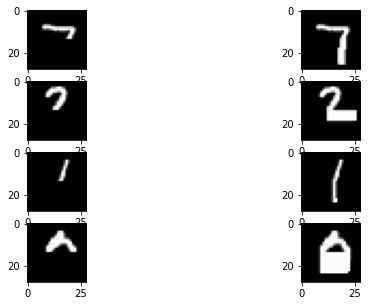

In [123]:
fig = plt.figure(figsize=(9, 5))

for i in range(num_samples*2):
  sub = fig.add_subplot(num_samples, 2, i+1)
  if(i%2):
    sub.imshow(reshapes[int(i/2)], cmap='gray')
  else:
    sub.imshow(sample[int(i/2)], cmap='gray')